In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.lines as mlines
from pylab import bone, pcolor, colorbar, plot, show

!pip install minisom
from minisom import MiniSom

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10609 sha256=2f1b63d9090761b86141989a2ecd1cb6d61e0d88e6ea19e194f30366eefe5ba0
  Stored in directory: /root/.cache/pip/wheels/b4/aa/7a/d9a88098f7877aa95dd4f227fe614f75773654baa39b47bba6
Successfully built minisom


In [2]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [3]:
def calculate_quantiles(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25, q75 + 1.5 * iqr)
    return boundaries

In [4]:
def set_outliers_to_boundary(df):

    # separate the features and target variable, assuming the target variable is not used for outlier detection
    X = df.drop('Age', axis=1)

    # fit the IsolationForest model to the data
    isof = IsolationForest(random_state=42, contamination=0.05)
    isof.fit(X)

    # predict the outlier status of each observation in the dataset
    outlier_preds = isof.predict(X)

    # replace the outlier values with the upper boundary calculated by the IQR method
    for i, pred in enumerate(outlier_preds):
        if pred == -1:
            # this observation is an outlier, replace the values with the upper boundary
            upper_boundary = calculate_outliers(X.iloc[i])
            X.iloc[i] = X.iloc[i].clip(upper=upper_boundary[1])
    
    # concatenate the cleaned features and target variable (if applicable) into a new DataFrame
    cleaned_df = pd.concat([X, df['Age']], axis=1)

    return cleaned_df

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but I

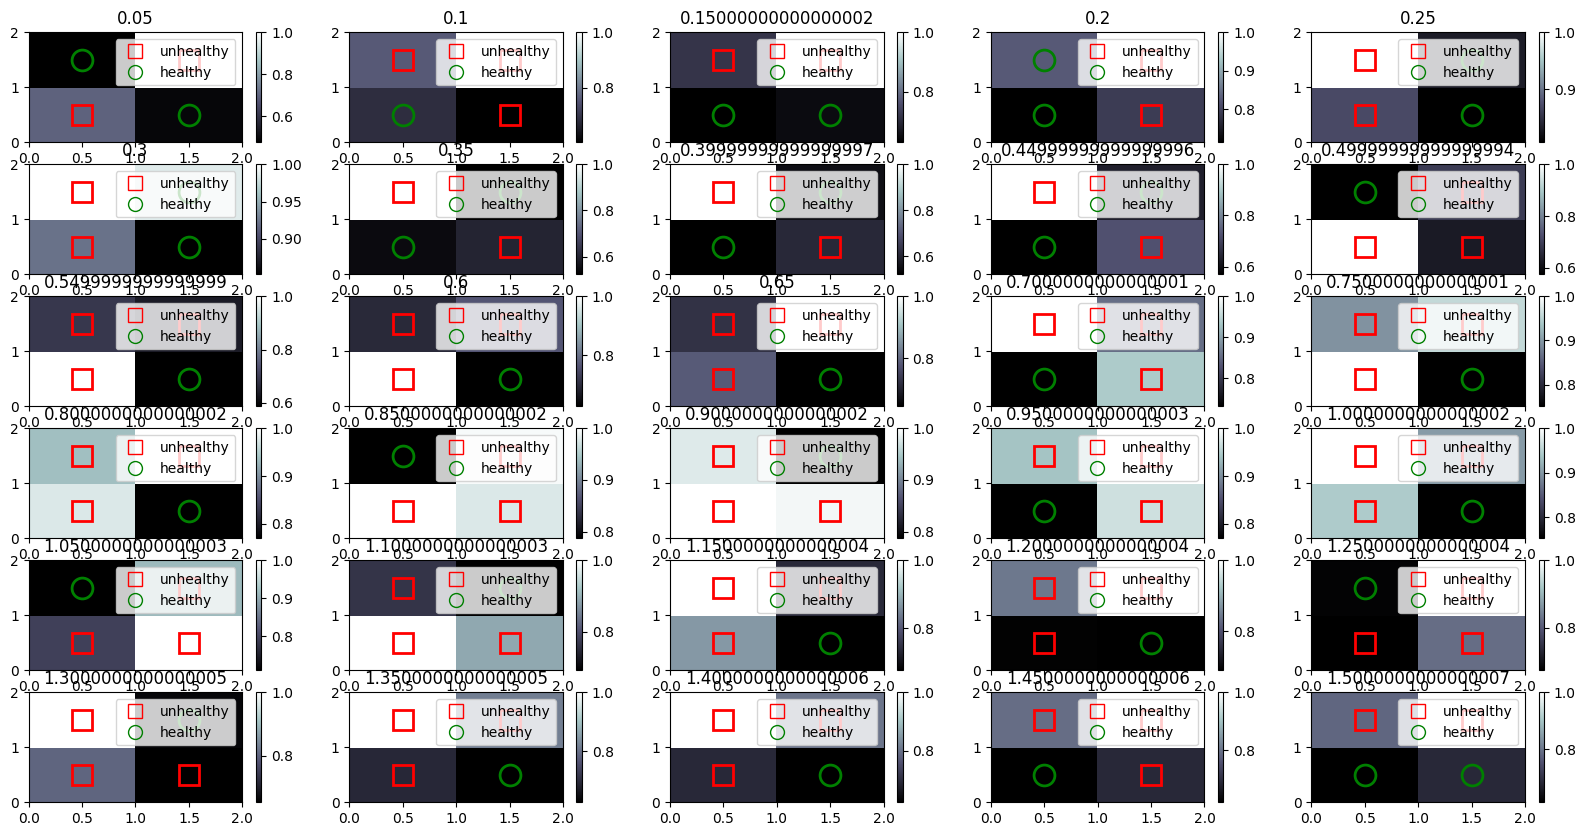

In [5]:
plt.figure(figsize = (20,10))
lr = 0
losses = []
learning_rates = []
for i in range(30):
  lr += 0.05
  learning_rates.append(lr)
  plt.subplot(6,5,i+1)
  plt.title(lr)

  main_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 
                                                                                             'Age_Child', 
                                                                                             'Age_Adult',
                                                                                             'Age_Infant',
                                                                                             'Age_Elderly',
                                                                                             'Age_Mix',
                                                                                             'Health_Status', 
                                                                                             'Archaeal', 
                                                                                             'Bacteriophage', 
                                                                                             'Eukaryotic', 
                                                                                             'crassphage'], axis=1)
  
  main_df['Age'] = main_df['Age'].map({'Child': 0, 'Infant': 1, 'Adult': 2, 'Elderly': 4, 'Mix': 3})

  # main_df = main_df[main_df['Age_Mix'] != 1.0].drop(['Age_Mix'], axis=1)

  target = 'Healthy'

  X = main_df.loc[:,main_df.columns!=target]
  y = main_df.loc[:,main_df.columns==target]

  oversample = SMOTENC(categorical_features=[0], random_state=42)
  X, y = oversample.fit_resample(X, y)

  X = set_outliers_to_boundary(X)

  # selector = SelectKBest(score_func=f_regression, k=10)
  # selector.fit(X, y)

  # imp_viruses = X.columns[selector.get_support()]
  imp_viruses = ['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']

  # X = X[imp_viruses]

  sc = MinMaxScaler()
  X = sc.fit_transform(X)

  # X = X.values
  y = y.values 

  # som_size = 2
  som_size_0 = 2
  som_size_1 = 2

  som = MiniSom(x=som_size_0, y=som_size_1, input_len=29, sigma=1.0, learning_rate=lr, random_seed=42, 
                topology='rectangular', 
                activation_distance='euclidean',
                neighborhood_function='gaussian')
  som.random_weights_init(X)
  som.train_batch(data=X, num_iteration=300)

  losses.append(som.quantization_error(X))

  # plt.figure(figsize = (20,10))
  bone()
  pcolor(som.distance_map().T)
  colorbar() 

  markers = ['o', 's']
  colors = ['green', 'red']
  status = ['healthy', 'unhealthy']

  ls_tmp = []
  healthy_matrix = np.zeros((som_size_0,som_size_1))
  unhealthy_matrix = np.zeros((som_size_0,som_size_1))

  for i, j in enumerate(X):          
      wn = som.winner(j)         
      if y[i] == 1:
          unhealthy_matrix[wn[0], wn[1]] += 1
      elif y[i] == 0:
          healthy_matrix[wn[0], wn[1]] += 1
          
  result_resent_matrix = unhealthy_matrix/(healthy_matrix + unhealthy_matrix)

  for i in range(som_size_0):
    for j in range(som_size_1):
      if result_resent_matrix[i,j] > 0.5:
        plot(i + 0.5, j + 0.5, markers[1], markeredgecolor = colors[1], markerfacecolor = 'None', markersize=15, markeredgewidth = 2)
      elif result_resent_matrix[i,j] <= 0.5:
        plot(i + 0.5, j + 0.5, markers[0], markeredgecolor = colors[0], markerfacecolor = 'None', markersize=15, markeredgewidth = 2)
      
  red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markerfacecolor = 'None',
                            markersize=10, label='unhealthy')
  green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor = 'None',
                            markersize=10, label='healthy')
  plt.legend(handles=[red_square, green_circle], loc=1)

Text(0, 0.5, 'loss')

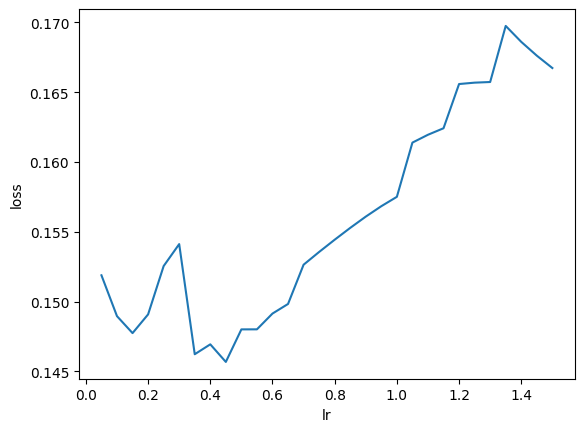

In [6]:
plt.plot(learning_rates, losses)
plt.xlabel('lr')
plt.ylabel('loss')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


70.37037037037037


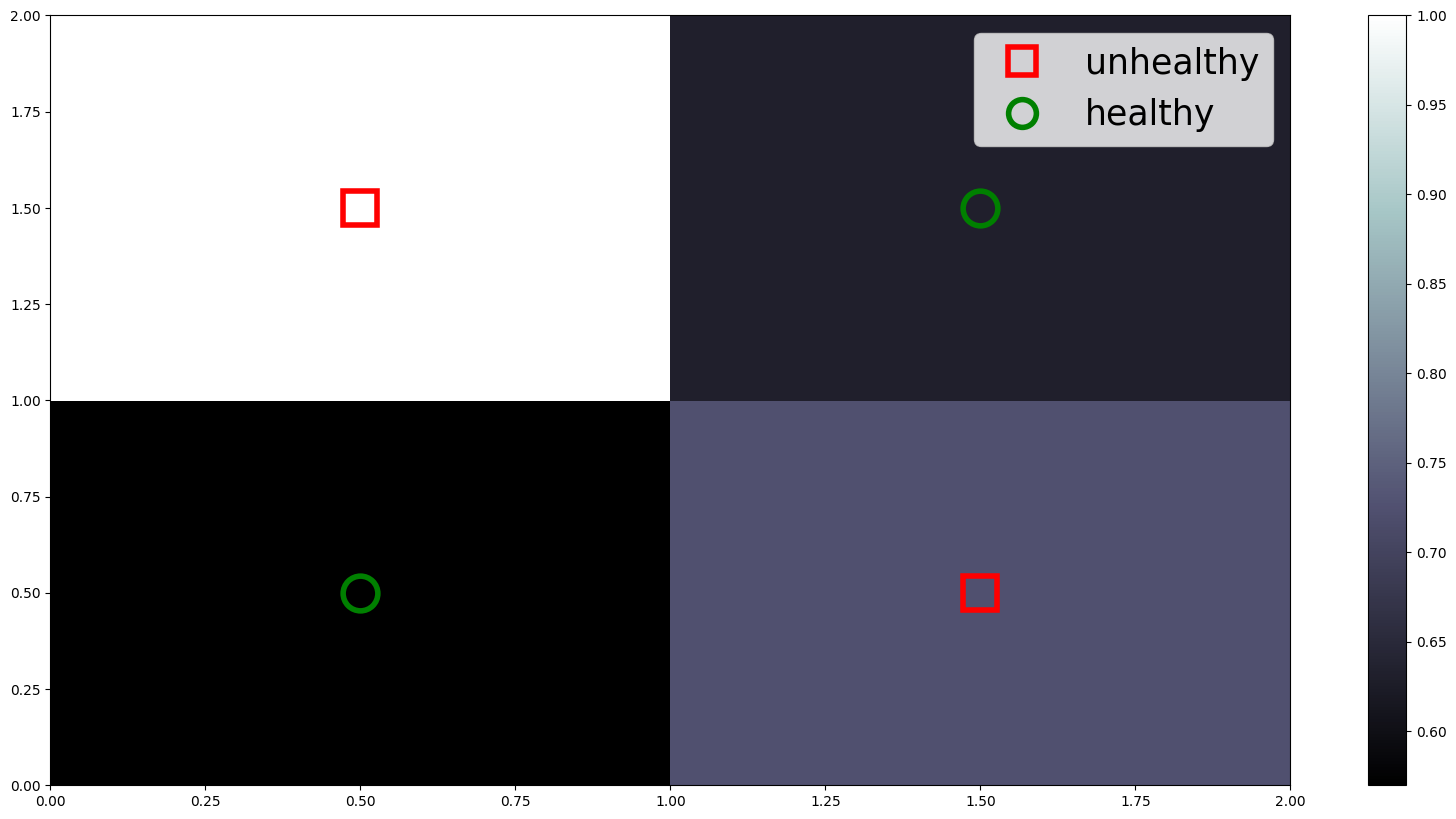

In [7]:
main_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 
                                                                                           'Age_Child', 
                                                                                           'Age_Adult',
                                                                                           'Age_Infant',
                                                                                           'Age_Elderly',
                                                                                           'Age_Mix',
                                                                                           'Health_Status', 
                                                                                           'Archaeal', 
                                                                                           'Bacteriophage', 
                                                                                           'Eukaryotic', 
                                                                                           'crassphage'], axis=1) 
# main_df = main_df[main_df['Age_Mix'] != 1.0].drop(['Age_Mix'], axis=1) 

main_df['Age'] = main_df['Age'].map({'Child': 0, 'Infant': 1, 'Adult': 2, 'Elderly': 4, 'Mix': 3})

target = 'Healthy'
X = main_df.loc[:,main_df.columns!=target]
y = main_df.loc[:,main_df.columns==target]

oversample = SMOTENC(categorical_features=[0], random_state=42)
X, y = oversample.fit_resample(X, y)

X = set_outliers_to_boundary(X)

# selector = SelectKBest(score_func=f_regression, k=15)
# selector.fit(X, y)

# selected_columns = X.columns[selector.get_support()]
imp_viruses = ['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']

# X = X[imp_viruses]
columns_main = X.columns

sc = MinMaxScaler()
X = sc.fit_transform(X)
# virus_ml_df = pd.concat([X, y], axis=1)


# X = X.values
y = y.values

som_size = 2
som = MiniSom(x=som_size, y=som_size, input_len=29, sigma=1.0, learning_rate=0.45, random_seed=42)
som.random_weights_init(X)
som.train_batch(data=X, num_iteration=300)

plt.figure(figsize = (20,10))
bone()
pcolor(som.distance_map().T)
colorbar() 

markers = ['o', 's']
colors = ['green', 'red']
status = ['healthy', 'unhealthy']

ls_tmp = []

healthy_matrix = np.zeros((som_size,som_size))
unhealthy_matrix = np.zeros((som_size,som_size))

for i, j in enumerate(X):          
    wn = som.winner(j)         
    if wn[0] == 0:
      if wn[1] == 1:
        ls_tmp.append(int(y[i]))

    if y[i] == 1:
        unhealthy_matrix[wn[0], wn[1]] += 1
    elif y[i] == 0:
        healthy_matrix[wn[0], wn[1]] += 1
        
result_resent_matrix = unhealthy_matrix/(healthy_matrix + unhealthy_matrix)
for i in range(som_size):
  for j in range(som_size):
    if result_resent_matrix[i,j] > 0.5:
      plot(i + 0.5, j + 0.5, markers[1], markeredgecolor = colors[1], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)
    elif result_resent_matrix[i,j] <= 0.5:
      plot(i + 0.5, j + 0.5, markers[0], markeredgecolor = colors[0], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)

red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='unhealthy')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='healthy')
plt.legend(handles=[red_square, green_circle], loc=1, fontsize=25)

print(ls_tmp.count(1)/(ls_tmp.count(0)+ls_tmp.count(1))*100)

In [8]:
som.distance_map().T

array([[0.56971432, 0.72399035],
       [1.        , 0.63170526]])

In [9]:
mappings = som.win_map(X) 
result = mappings[(0,1)]
result = sc.inverse_transform(result)
df_result = pd.DataFrame(result)
df_result['Healthy'] = ls_tmp
columns_old = df_result.columns.tolist()[:-1]

for i in range(len(columns_old)):
  df_result = df_result.rename({columns_old[i]: columns_main[i]}, axis=1)

In [10]:
df = df_result[imp_viruses]
df['Healthy'] = ls_tmp
df_disease_high = df[df['Healthy']==1]
df_disease_high.shape

<ipython-input-10-8058d3fc0c59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Healthy'] = ls_tmp


(133, 5)

In [11]:
df_critical_values_disease_test = pd.DataFrame()
for col in df_disease_high.columns:
    col_outliers = calculate_quantiles(df_disease_high[col])
    # col_max = virus_ml_df[col].max()
    col_stats = {'q25-disease': col_outliers[0],
                 'q50-disease': df_disease_high[col].median(),
                 'q75-disease': col_outliers[1]}
    df_critical_values_disease_test[col] = pd.Series(col_stats)
df_critical_values_disease_test = df_critical_values_disease_test.drop(['Healthy'], axis=1).T
print('Unhealthy ranges for Total dataset -- test')
df_critical_values_disease_test

Unhealthy ranges for Total dataset -- test


,q25-disease,q50-disease,q75-disease
Myoviridae,0.0,0.0,0.000
Siphoviridae,0.0,0.0,13.075
Podoviridae,0.0,0.0,5.225
Microviridae,0.0,0.0,0.000


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


86.61417322834646


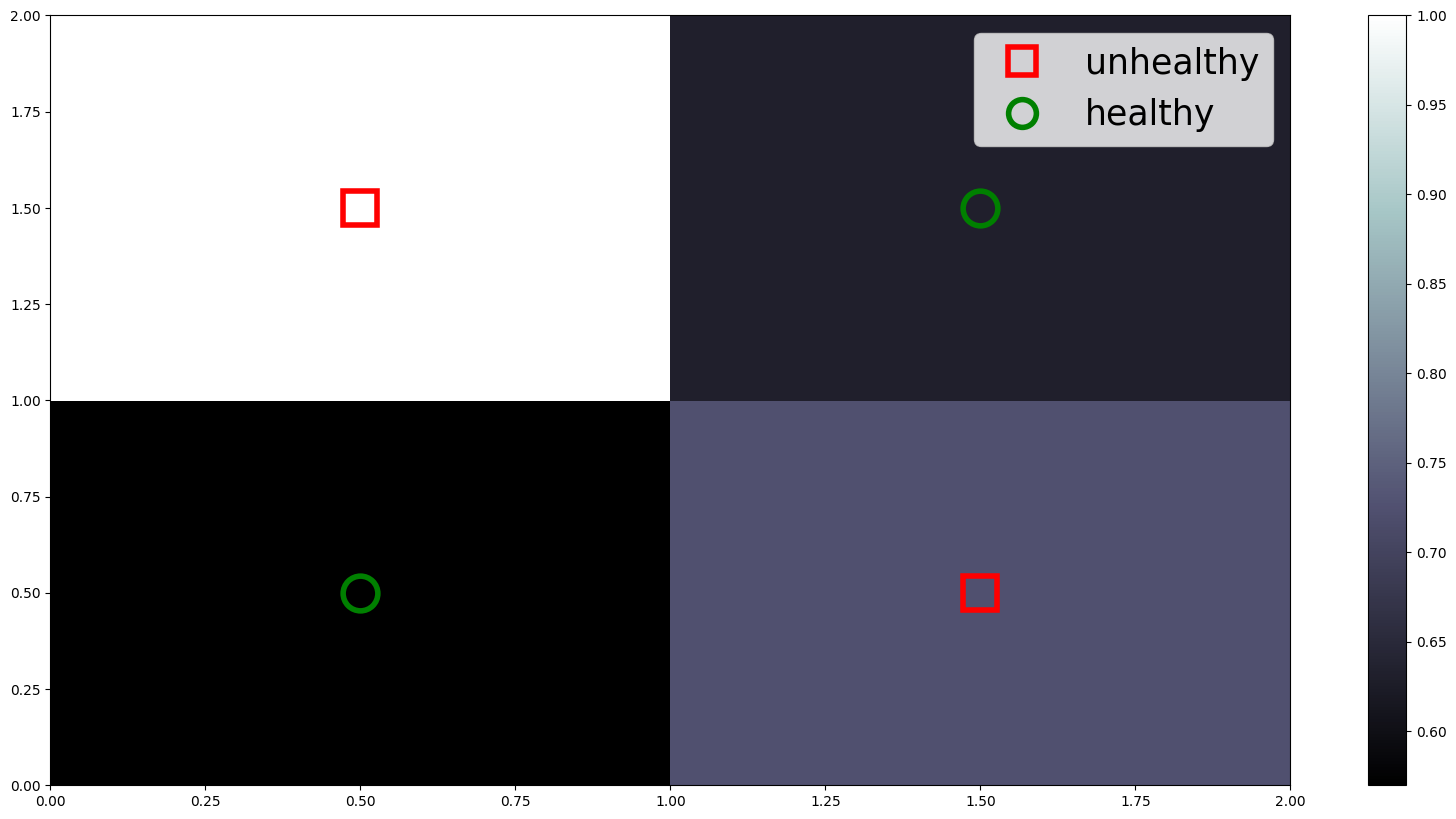

In [12]:
main_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 
                                                                                           'Age_Child', 
                                                                                           'Age_Adult',
                                                                                           'Age_Infant',
                                                                                           'Age_Elderly',
                                                                                           'Age_Mix',
                                                                                           'Health_Status', 
                                                                                           'Archaeal', 
                                                                                           'Bacteriophage', 
                                                                                           'Eukaryotic', 
                                                                                           'crassphage'], axis=1) 
# main_df = main_df[main_df['Age_Mix'] != 1.0].drop(['Age_Mix'], axis=1) 

main_df['Age'] = main_df['Age'].map({'Child': 0, 'Infant': 1, 'Adult': 2, 'Elderly': 4, 'Mix': 3})

target = 'Healthy'
X = main_df.loc[:,main_df.columns!=target]
y = main_df.loc[:,main_df.columns==target]

oversample = SMOTENC(categorical_features=[0], random_state=42)
X, y = oversample.fit_resample(X, y)

X = set_outliers_to_boundary(X)

# selector = SelectKBest(score_func=f_regression, k=15)
# selector.fit(X, y)

# selected_columns = X.columns[selector.get_support()]
imp_viruses = ['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']

# X = X[imp_viruses]
columns_main = X.columns

sc = MinMaxScaler()
X = sc.fit_transform(X)
# virus_ml_df = pd.concat([X, y], axis=1)


# X = X.values
y = y.values

som_size = 2
som = MiniSom(x=som_size, y=som_size, input_len=29, sigma=1.0, learning_rate=0.45, random_seed=42)
som.random_weights_init(X)
som.train_batch(data=X, num_iteration=300)

plt.figure(figsize = (20,10))
bone()
pcolor(som.distance_map().T)
colorbar() 

markers = ['o', 's']
colors = ['green', 'red']
status = ['healthy', 'unhealthy']

ls_tmp = []

healthy_matrix = np.zeros((som_size,som_size))
unhealthy_matrix = np.zeros((som_size,som_size))

for i, j in enumerate(X):          
    wn = som.winner(j)         
    if wn[0] == 1:
      if wn[1] == 0:
        ls_tmp.append(int(y[i]))

    if y[i] == 1:
        unhealthy_matrix[wn[0], wn[1]] += 1
    elif y[i] == 0:
        healthy_matrix[wn[0], wn[1]] += 1
        
result_resent_matrix = unhealthy_matrix/(healthy_matrix + unhealthy_matrix)
for i in range(som_size):
  for j in range(som_size):
    if result_resent_matrix[i,j] > 0.5:
      plot(i + 0.5, j + 0.5, markers[1], markeredgecolor = colors[1], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)
    elif result_resent_matrix[i,j] <= 0.5:
      plot(i + 0.5, j + 0.5, markers[0], markeredgecolor = colors[0], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)

red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='unhealthy')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='healthy')
plt.legend(handles=[red_square, green_circle], loc=1, fontsize=25)

print(ls_tmp.count(1)/(ls_tmp.count(0)+ls_tmp.count(1))*100)

In [13]:
som.distance_map().T

array([[0.56971432, 0.72399035],
       [1.        , 0.63170526]])

In [14]:
mappings = som.win_map(X) 
result = mappings[(1,0)]
result = sc.inverse_transform(result)
df_result = pd.DataFrame(result)
df_result['Healthy'] = ls_tmp
columns_old = df_result.columns.tolist()[:-1]

for i in range(len(columns_old)):
  df_result = df_result.rename({columns_old[i]: columns_main[i]}, axis=1)

In [15]:
df = df_result[imp_viruses]
df['Healthy'] = ls_tmp
df_disease_medium = df[df['Healthy']==1]
df_disease_medium.shape

<ipython-input-15-b9dc3c9faaf2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Healthy'] = ls_tmp


(110, 5)

In [16]:
result_disease = pd.concat([df_disease_high, df_disease_medium])

In [17]:
result_disease.shape

(243, 5)

In [18]:
df_critical_values_disease = pd.DataFrame()
for col in result_disease.columns:
    col_outliers = calculate_quantiles(result_disease[col])
    # col_max = virus_ml_df[col].max()
    col_stats = {'q25-disease': col_outliers[0],
                 'meadian-disease': result_disease[col].median(),
                 'q75-disease': col_outliers[1]}
    df_critical_values_disease[col] = pd.Series(col_stats)
df_critical_values_disease = df_critical_values_disease.drop(['Healthy'], axis=1).T
print('Unhealthy ranges for Total dataset')
df_critical_values_disease

Unhealthy ranges for Total dataset


,q25-disease,meadian-disease,q75-disease
Myoviridae,0.0,1.360,9.63750
Siphoviridae,0.0,4.950,19.97500
Podoviridae,0.0,0.666,4.55000
Microviridae,0.0,0.000,0.56625


## Healthy -- all

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


61.60337552742617


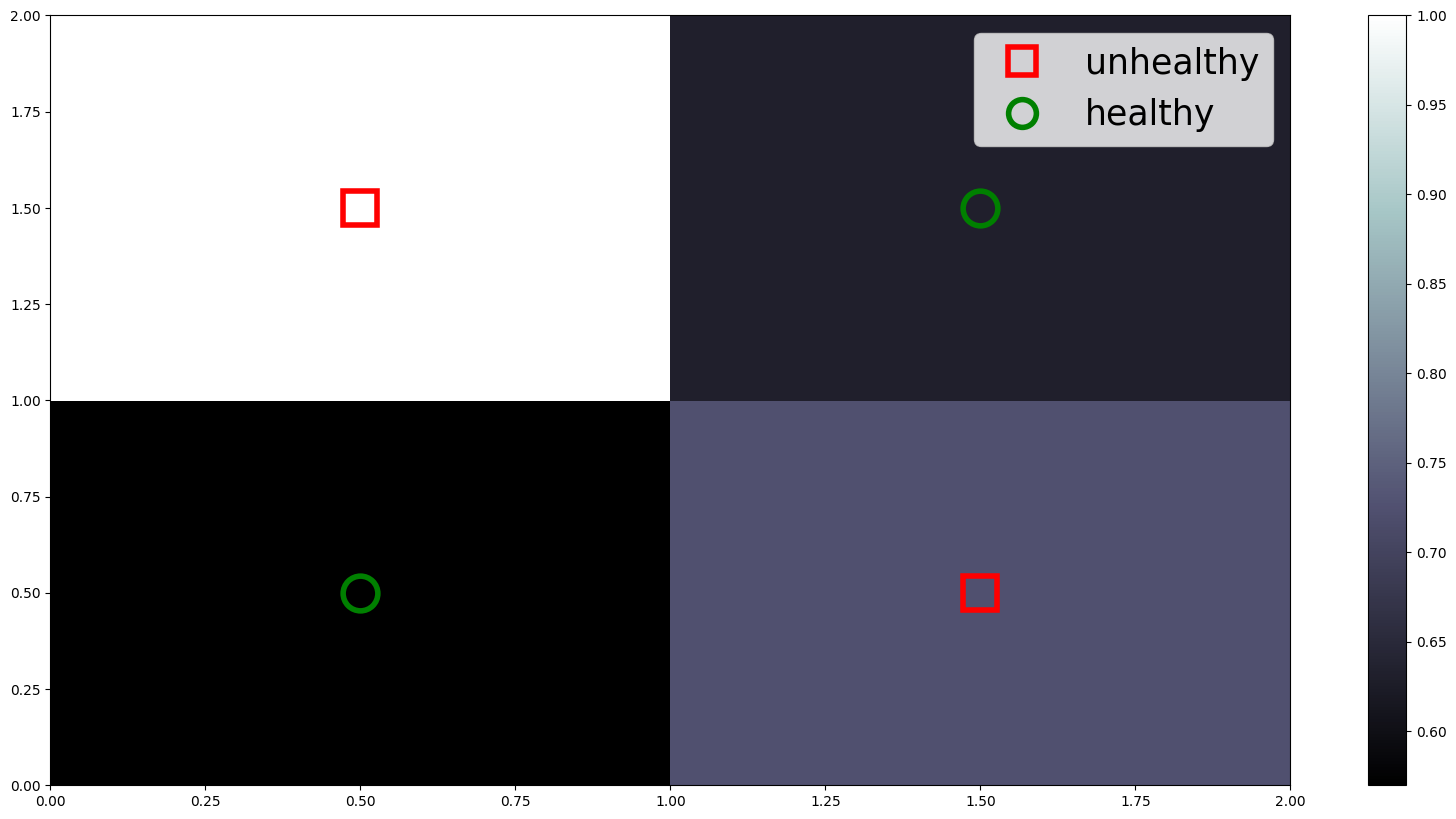

In [19]:
main_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 
                                                                                           'Age_Child', 
                                                                                           'Age_Adult',
                                                                                           'Age_Infant',
                                                                                           'Age_Elderly',
                                                                                           'Age_Mix',
                                                                                           'Health_Status', 
                                                                                           'Archaeal', 
                                                                                           'Bacteriophage', 
                                                                                           'Eukaryotic', 
                                                                                           'crassphage'], axis=1) 
# main_df = main_df[main_df['Age_Mix'] != 1.0].drop(['Age_Mix'], axis=1) 

main_df['Age'] = main_df['Age'].map({'Child': 0, 'Infant': 1, 'Adult': 2, 'Elderly': 4, 'Mix': 3})

target = 'Healthy'
X = main_df.loc[:,main_df.columns!=target]
y = main_df.loc[:,main_df.columns==target]

oversample = SMOTENC(categorical_features=[0], random_state=42)
X, y = oversample.fit_resample(X, y)

X = set_outliers_to_boundary(X)

# selector = SelectKBest(score_func=f_regression, k=15)
# selector.fit(X, y)

# selected_columns = X.columns[selector.get_support()]
imp_viruses = ['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']

# X = X[imp_viruses]
columns_main = X.columns
sc = MinMaxScaler()
X = sc.fit_transform(X)
# virus_ml_df = pd.concat([X, y], axis=1)

# X = X.values
y = y.values

som_size = 2
som = MiniSom(x=som_size, y=som_size, input_len=29, sigma=1.0, learning_rate=0.45, random_seed=42)
som.random_weights_init(X)
som.train_batch(data=X, num_iteration=300)

plt.figure(figsize = (20,10))
bone()
pcolor(som.distance_map().T)
colorbar() 

markers = ['o', 's']
colors = ['green', 'red']
status = ['healthy', 'unhealthy']

ls_tmp = []

healthy_matrix = np.zeros((som_size,som_size))
unhealthy_matrix = np.zeros((som_size,som_size))

for i, j in enumerate(X):          
    wn = som.winner(j)         
    if wn[0] == 0:
      if wn[1] == 0:
        ls_tmp.append(int(y[i]))

    if y[i] == 1:
        unhealthy_matrix[wn[0], wn[1]] += 1
    elif y[i] == 0:
        healthy_matrix[wn[0], wn[1]] += 1
        
result_resent_matrix = unhealthy_matrix/(healthy_matrix + unhealthy_matrix)
for i in range(som_size):
  for j in range(som_size):
    if result_resent_matrix[i,j] > 0.5:
      plot(i + 0.5, j + 0.5, markers[1], markeredgecolor = colors[1], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)
    elif result_resent_matrix[i,j] <= 0.5:
      plot(i + 0.5, j + 0.5, markers[0], markeredgecolor = colors[0], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)

red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='unhealthy')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='healthy')
plt.legend(handles=[red_square, green_circle], loc=1, fontsize=25)

print(ls_tmp.count(0)/(ls_tmp.count(0)+ls_tmp.count(1))*100)

In [20]:
som.distance_map().T

array([[0.56971432, 0.72399035],
       [1.        , 0.63170526]])

In [21]:
mappings = som.win_map(X) 
result = mappings[(0,0)]
result = sc.inverse_transform(result)
df_result = pd.DataFrame(result)
df_result['Healthy'] = ls_tmp
print(df_result.shape)

columns_old = df_result.columns.tolist()[:-1]

# columns_main = main_df.drop(['Healthy'], axis=1).columns.tolist()

for i in range(len(columns_old)):
  df_result = df_result.rename({columns_old[i]: columns_main[i]}, axis=1)
df_result.head()

(237, 30)


,Ackermannviridae,Adenoviridae,Alphaflexiviridae,Anelloviridae,Asfarviridae,Astroviridae,Bicaudaviridae,Caliciviridae,Circoviridae,Cruliviridae,...,Picornaviridae,Podoviridae,Polyomaviridae,Poxviridae,Rudiviridae,Siphoviridae,Smacoviridae,Virgaviridae,Age,Healthy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,39.9,0.0,0.0,2.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.30,0.0,0.0,0.0,27.9,0.0,0.0,2.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,23.0,0.0,0.0,2.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.74,0.0,0.0,0.0,24.3,0.0,0.0,2.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.71,0.0,0.0,0.0,21.8,0.0,0.0,2.0,1


In [22]:
# df = df_result[['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']]
df = df_result[imp_viruses]
df['Healthy'] = ls_tmp
df_healthy_low = df[df['Healthy']==0]
df_healthy_low.shape

<ipython-input-22-d9b30c43e510>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Healthy'] = ls_tmp


(146, 5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


52.708431464908145


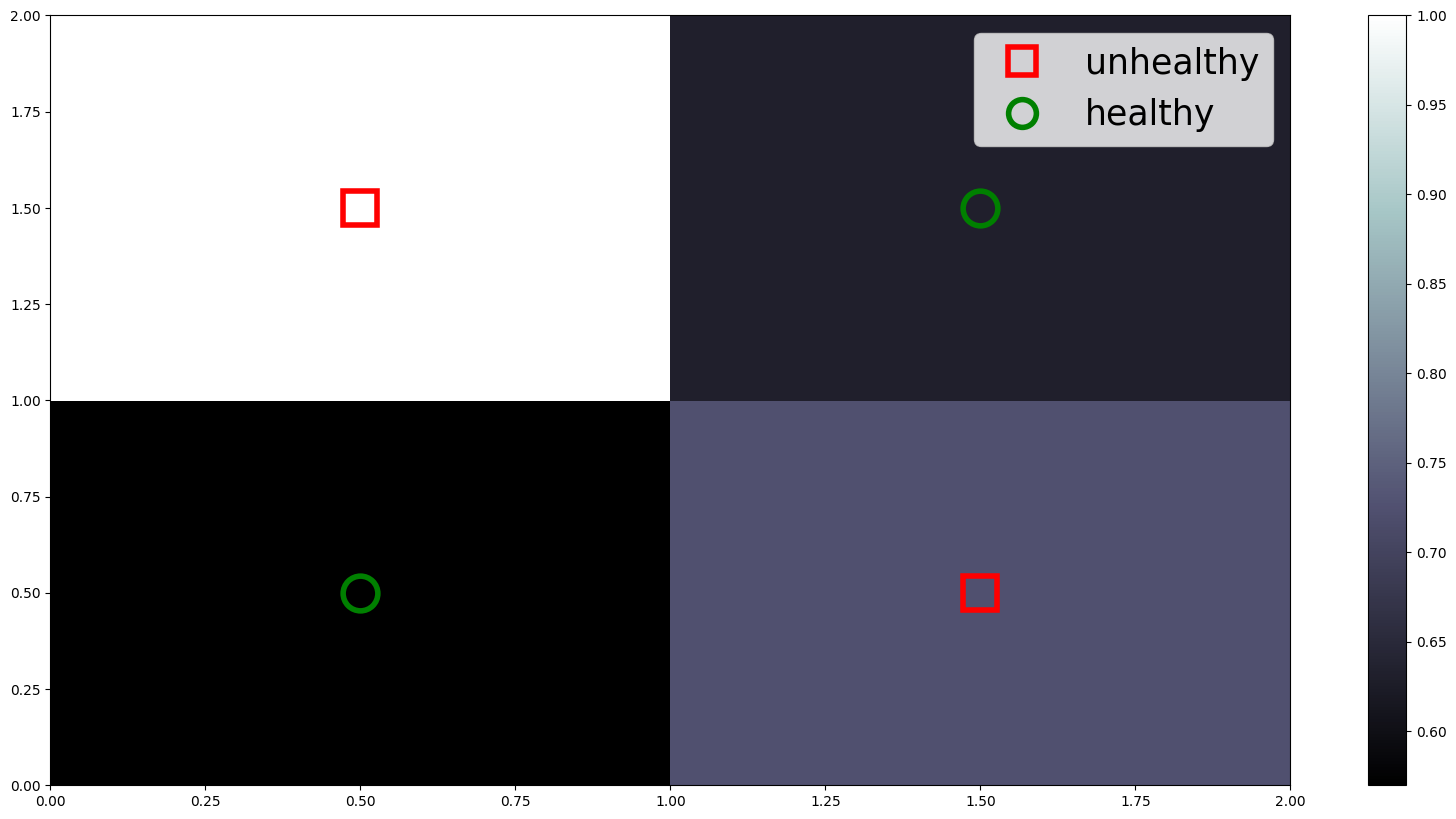

In [23]:
main_df = pd.read_csv('drive/MyDrive/ColabNotebooks/UMA/virus_df_full_only_age.csv').drop(['Country', 
                                                                                           'Age_Child', 
                                                                                           'Age_Adult',
                                                                                           'Age_Infant',
                                                                                           'Age_Elderly',
                                                                                           'Age_Mix',
                                                                                           'Health_Status', 
                                                                                           'Archaeal', 
                                                                                           'Bacteriophage', 
                                                                                           'Eukaryotic', 
                                                                                           'crassphage'], axis=1) 
# main_df = main_df[main_df['Age_Mix'] != 1.0].drop(['Age_Mix'], axis=1) 

main_df['Age'] = main_df['Age'].map({'Child': 0, 'Infant': 1, 'Adult': 2, 'Elderly': 4, 'Mix': 3})

target = 'Healthy'
X = main_df.loc[:,main_df.columns!=target]
y = main_df.loc[:,main_df.columns==target]

oversample = SMOTENC(categorical_features=[0], random_state=42)
X, y = oversample.fit_resample(X, y)

X = set_outliers_to_boundary(X)

# selector = SelectKBest(score_func=f_regression, k=15)
# selector.fit(X, y)

# selected_columns = X.columns[selector.get_support()]
imp_viruses = ['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']

# X = X[imp_viruses]
columns_main = X.columns
sc = MinMaxScaler()
X = sc.fit_transform(X)
# virus_ml_df = pd.concat([X, y], axis=1)

# X = X.values
y = y.values

som_size = 2
som = MiniSom(x=som_size, y=som_size, input_len=29, sigma=1.0, learning_rate=0.45, random_seed=42)
som.random_weights_init(X)
som.train_batch(data=X, num_iteration=300)

plt.figure(figsize = (20,10))
bone()
pcolor(som.distance_map().T)
colorbar() 

markers = ['o', 's']
colors = ['green', 'red']
status = ['healthy', 'unhealthy']

ls_tmp = []

healthy_matrix = np.zeros((som_size,som_size))
unhealthy_matrix = np.zeros((som_size,som_size))

for i, j in enumerate(X):          
    wn = som.winner(j)         
    if wn[0] == 1:
      if wn[1] == 1:
        ls_tmp.append(int(y[i]))

    if y[i] == 1:
        unhealthy_matrix[wn[0], wn[1]] += 1
    elif y[i] == 0:
        healthy_matrix[wn[0], wn[1]] += 1
        
result_resent_matrix = unhealthy_matrix/(healthy_matrix + unhealthy_matrix)
for i in range(som_size):
  for j in range(som_size):
    if result_resent_matrix[i,j] > 0.5:
      plot(i + 0.5, j + 0.5, markers[1], markeredgecolor = colors[1], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)
    elif result_resent_matrix[i,j] <= 0.5:
      plot(i + 0.5, j + 0.5, markers[0], markeredgecolor = colors[0], markerfacecolor = 'None', markersize=25, markeredgewidth = 4)

red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='unhealthy')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markerfacecolor = 'None',
                          markersize=20, markeredgewidth=4, label='healthy')
plt.legend(handles=[red_square, green_circle], loc=1, fontsize=25)

print(ls_tmp.count(0)/(ls_tmp.count(0)+ls_tmp.count(1))*100)

In [24]:
som.distance_map().T

array([[0.56971432, 0.72399035],
       [1.        , 0.63170526]])

In [25]:
mappings = som.win_map(X) 
result = mappings[(1,1)]
result = sc.inverse_transform(result)
df_result = pd.DataFrame(result)
df_result['Healthy'] = ls_tmp
print(df_result.shape)

columns_old = df_result.columns.tolist()[:-1]

# columns_main = main_df.drop(['Healthy'], axis=1).columns.tolist()

for i in range(len(columns_old)):
  df_result = df_result.rename({columns_old[i]: columns_main[i]}, axis=1)
df_result.head()

(2123, 30)


,Ackermannviridae,Adenoviridae,Alphaflexiviridae,Anelloviridae,Asfarviridae,Astroviridae,Bicaudaviridae,Caliciviridae,Circoviridae,Cruliviridae,...,Picornaviridae,Podoviridae,Polyomaviridae,Poxviridae,Rudiviridae,Siphoviridae,Smacoviridae,Virgaviridae,Age,Healthy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,10.80,0.0,0.0,2.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,2.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.46,0.0,0.0,0.0,2.30,0.0,0.0,2.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.55,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,2.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,5.77,0.0,0.0,2.0,1


In [26]:
# df = df_result[['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']]
df = df_result[imp_viruses]
df['Healthy'] = ls_tmp
df_healthy_medium = df[df['Healthy']==0]
df_healthy_medium.shape

<ipython-input-26-31d812e79839>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Healthy'] = ls_tmp


(1119, 5)

In [27]:
result_healthy = pd.concat([df_healthy_medium, df_healthy_low])

In [28]:
result_healthy.shape

(1265, 5)

In [29]:
df_critical_values_healthy = pd.DataFrame()
for col in result_healthy.columns:
    col_outliers = calculate_quantiles(result_healthy[col])
    # col_max = virus_ml_df[col].max()
    col_stats = {'q25-healthy': col_outliers[0],
                 'meadian-healthy': result_healthy[col].median(),
                 'q75-healthy': col_outliers[1]}
    df_critical_values_healthy[col] = pd.Series(col_stats)
df_critical_values_healthy = df_critical_values_healthy.drop(['Healthy'], axis=1).T
print("Healthy range for Total dataset")
df_critical_values_healthy

Healthy range for Total dataset


,q25-healthy,meadian-healthy,q75-healthy
Myoviridae,0.000000,0.954410,5.714968
Siphoviridae,1.583728,5.440000,20.849408
Podoviridae,0.446471,1.869717,14.355293
Microviridae,0.000000,0.739637,12.000000


In [30]:
result_ranges = pd.concat([df_critical_values_disease, df_critical_values_healthy], axis=1, join="inner")
result_ranges

,q25-disease,meadian-disease,q75-disease,q25-healthy,meadian-healthy,q75-healthy
Myoviridae,0.0,1.360,9.63750,0.000000,0.954410,5.714968
Siphoviridae,0.0,4.950,19.97500,1.583728,5.440000,20.849408
Podoviridae,0.0,0.666,4.55000,0.446471,1.869717,14.355293
Microviridae,0.0,0.000,0.56625,0.000000,0.739637,12.000000


In [31]:
df_critical_values_disease_high = pd.DataFrame()
for col in df_disease_high.columns:
    col_outliers = calculate_quantiles(df_disease_high[col])
    # col_max = virus_ml_df[col].max()
    col_stats = {'q25-healthy': col_outliers[0],
                 'q50-healthy': df_disease_high[col].median(),
                 'q75-healthy': col_outliers[1]}
    df_critical_values_disease_high[col] = pd.Series(col_stats)
df_critical_values_disease_high = df_critical_values_disease_high.drop(['Healthy'], axis=1).T
print("Disease 'high' atypical range for Total dataset")
df_critical_values_disease_high

Disease 'high' atypical range for Total dataset


,q25-healthy,q50-healthy,q75-healthy
Myoviridae,0.0,0.0,0.000
Siphoviridae,0.0,0.0,13.075
Podoviridae,0.0,0.0,5.225
Microviridae,0.0,0.0,0.000


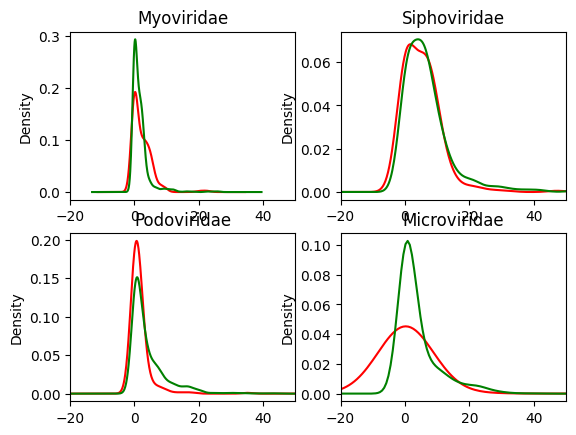

In [32]:
for i, virus in enumerate(['Myoviridae', 'Siphoviridae', 'Podoviridae', 'Microviridae']):
  plt.subplot(2, 2, i+1)
  # result_disease[virus].plot.hist(bins=50, alpha=0.5, color='red')
  # result_healthy[virus].plot.hist(bins=50, alpha=0.5, color='green')
  result_disease[virus].plot.density(color='red')
  result_healthy[virus].plot.density(color='green')
  plt.title(virus)
  plt.xlim([-20, 50])